In [1]:
%matplotlib inline

from collections import defaultdict

from Bio import Entrez
from Bio import Geo
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

# Загрузка данных

Данные получены в soft формате. Данные нормализованы квантильным методом. Дубликаты в исходных данных были решены взятием медианы нормального сигнала отдельно по каждому набору репликатов.

Загрузка данных происходит при помощи `Bio.Geo` из пакета **biopython**.

В колонке **TYPE** хранится тип образец: control, low_dose, high_dose

В колонке **SAMPLE** хранится имя образца из базы.

В остальных колонках хранятся данные по ген. экспрессии.

In [2]:
def load_data(filepath):
    df = defaultdict(list)
    sample_types = {
        "exposed to BPA at 50 µg/Kg/day": "low_dose",
        "exposed to BPA at 5000 µg/Kg/day": "high_dose",
        "control": "control"
    }
    repeats = 0
    with open(filepath) as handle:
        records = Geo.parse(handle)
        for i, record in enumerate(records):
            if record.entity_type != "SAMPLE":
                continue
            char = record.entity_attributes["Sample_characteristics_ch1"]
            char = dict([x.split(": ") for x in char])
        
            df["TYPE"].append(sample_types[char["treatment"]])
            df["SAMPLE"].append(record.entity_attributes["Sample_geo_accession"]) 
            
            sample_data = defaultdict(list)
            for gene, value in record.table_rows[1:]:
                sample_data[gene].append(float(value))
                
            # Усредняется если есть повторения
            for k, v in sample_data.items():
                if len(v) > 1:
                    repeats += 1
                df[k].append(np.mean(v))
                
    df = pd.DataFrame(df)
    return df, repeats

In [3]:
df,repeats = load_data("./data/GSE26728_family.soft")
df

,TYPE,SAMPLE,A_51_P100034,A_51_P100063,A_51_P100099,A_51_P100155,A_51_P100174,A_51_P100181,A_51_P100227,A_51_P100246,...,A_52_P995381,A_52_P996032,A_52_P996473,A_52_P99665,A_52_P99670,A_52_P997209,A_52_P997449,A_52_P99807,A_52_P99848,A_52_P99888
0,control,GSM658075,12.630,5.828,7.638,10.947,6.632,6.655,8.205,9.787,...,7.651,8.821,5.901,7.842,7.712,7.734,10.070,8.176,6.951,7.445
1,control,GSM658076,11.899,6.598,7.635,10.582,6.089,6.788,8.194,9.590,...,7.246,8.740,6.098,8.468,7.174,8.105,9.784,7.628,7.187,6.946
2,control,GSM658077,12.393,5.984,7.216,10.406,6.012,6.584,8.335,9.846,...,7.240,8.799,6.142,8.023,7.613,7.841,9.009,7.993,7.154,7.340
3,control,GSM658078,12.539,5.986,7.767,11.054,6.190,6.822,8.146,9.733,...,7.352,8.063,6.114,7.959,7.846,7.631,10.071,7.717,6.452,7.277
4,control,GSM658079,12.368,6.089,7.516,10.770,6.260,6.742,8.153,9.027,...,7.582,8.553,5.856,8.037,8.000,7.893,9.762,6.355,7.582,7.379
5,control,GSM658080,12.361,6.163,7.378,10.402,6.131,6.782,8.252,9.852,...,6.988,8.428,5.963,7.943,7.264,8.232,9.535,6.668,6.585,7.173
6,low_dose,GSM658081,12.332,6.384,7.171,10.610,5.993,6.805,8.209,9.363,...,6.974,7.464,6.103,8.083,7.693,7.570,9.876,6.699,7.758,7.800
7,low_dose,GSM658082,12.148,6.410,7.558,10.512,6.274,6.822,8.303,9.166,...,7.362,8.489,6.444,8.218,6.954,8.146,9.999,7.256,6.601,7.264
8,low_dose,GSM658083,12.032,5.984,7.571,10.492,6.002,6.734,8.249,9.492,...,7.042,8.437,5.413,8.278,7.569,7.550,10.084,6.803,6.838,7.402
9,low_dose,GSM658084,11.955,6.158,7.607,10.485,6.011,6.954,8.120,9.592,...,7.047,8.243,6.283,7.079,8.165,7.820,10.064,8.208,6.869,7.138


Как видно, в обработанных данных отсутствуют дубликаты:

In [4]:
repeats

0

# Вычисление средних

## Контроль

In [5]:
control_df = df[df["TYPE"] == "control"]
control_df.iloc[:,2:].mean()

A_51_P100034    12.365000
A_51_P100063     6.108000
A_51_P100099     7.525000
A_51_P100155    10.693500
A_51_P100174     6.219000
                  ...    
A_52_P997209     7.906000
A_52_P997449     9.705167
A_52_P99807      7.422833
A_52_P99848      6.985167
A_52_P99888      7.260000
Length: 22514, dtype: float64

## Малые дозы

In [6]:
low_df = df[df["TYPE"] == "low_dose"]
low_df.iloc[:,2:].mean()

A_51_P100034    12.148500
A_51_P100063     6.133333
A_51_P100099     7.509667
A_51_P100155    10.578833
A_51_P100174     6.077667
                  ...    
A_52_P997209     7.734833
A_52_P997449    10.062500
A_52_P99807      7.397167
A_52_P99848      7.095833
A_52_P99888      7.335833
Length: 22514, dtype: float64

## Большие дозы

In [7]:
high_df = df[df["TYPE"] == "high_dose"]
high_df.iloc[:,2:].mean()

A_51_P100034    12.182333
A_51_P100063     6.648000
A_51_P100099     7.486667
A_51_P100155    10.473667
A_51_P100174     6.199500
                  ...    
A_52_P997209     7.924167
A_52_P997449     9.782667
A_52_P99807      6.939167
A_52_P99848      7.304333
A_52_P99888      7.363500
Length: 22514, dtype: float64

# Решающие деревья

## Контроль vs Малые дозы

In [8]:
control_low_df = pd.concat([control_df, low_df])
X = control_low_df.iloc[:, 2:]
y = control_low_df.iloc[:, 0]

clf_control_vs_low = DecisionTreeClassifier(random_state=56, max_depth=2)
clf_control_vs_low.fit(
    X,
    y
)

feature_index1 = clf_control_vs_low.tree_.feature[0]
print(f"Лучшим признаком для разделения является: {X.columns[feature_index1]}")

Лучшим признаком для разделения является: A_52_P45170


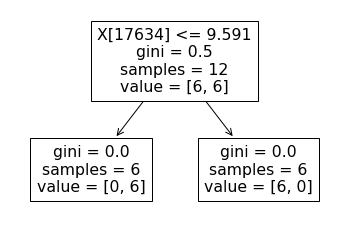

In [9]:
tree.plot_tree(clf_control_vs_low);

## Контроль vs Большие дозы

In [10]:
control_high_df = pd.concat([control_df, high_df])
X = control_high_df.iloc[:, 2:]
y = control_high_df.iloc[:, 0]

clf_control_vs_high = DecisionTreeClassifier(random_state=56, max_depth=2)
clf_control_vs_high.fit(
    X,
    y
)

feature_index2 = clf_control_vs_high.tree_.feature[0]
print(f"Лучшим признаком для разделения является: {X.columns[feature_index2]}")

Лучшим признаком для разделения является: A_52_P1687


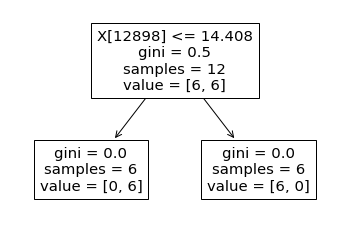

In [11]:
tree.plot_tree(clf_control_vs_high);

In [12]:
print("Лучшие признаки одинаковые" if feature_index2 == feature_index1 else "Лучшие признаки различны")

Лучшие признаки различны
